In [32]:
import pandas as pd
import xarray as xr
import dask.dataframe as dd
import hvplot.pandas  # noqa
import hvplot.dask  # noqa
import numpy as np
from scipy import stats
import datetime
import matplotlib.dates as dates

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from dask.distributed import Client

client = Client("tcp://10.0.131.0:38033")
client

Client Scheduler: tcp://10.0.131.0:38033 Dashboard: /user/jnatalie12/proxy/8787/status,Cluster Workers: 4 Cores: 4 Memory: 5.00 GB


In [5]:
!head '/home/jovyan/data/botpt/axial_seismic/hypo71_11_2019.txt'

yyyymmdd HHMM SSS.SS Lat(D M)  Lon(D M)  Depth    MW NWR GAP DMIN  RMS  ERH  ERZ            ID         PMom    SMom
20150122 0000 27.54 45 56.81 129 59.92   0.55  -0.31  7 206  1.2 0.03  0.8  0.4         20830      3.8e+17 3.9e+17
20150122 0008 58.89 45 56.96 129 59.70   0.00   0.02 10 149  1.2 0.09  0.2  0.2         20831      1.9e+18 7.8e+17
20150122 0202 41.04 45 56.47 130  0.89   0.67  -0.03 12 200  0.8 0.03  0.9  0.7         20836      1.4e+18 7.2e+17
20150122 0219 56.90 45 54.93 129 57.59   1.60   0.26  7 325  1.8 0.06  1.4  2.5         20837      3.3e+18 2.2e+18
20150122 0236  7.08 45 56.80 129 59.71   0.51  -0.15  8 160  1.2 0.06  0.5  0.2         20840      6.7e+17 6.8e+17
20150122 0239 20.66 45 56.93 129 59.48   1.56   0.07 12 148  0.9 0.08  0.5  1.3         20841      1.3e+18 1.6e+18
20150122 0242 34.06 45 56.70 129 59.34   1.09   0.27 12 108  0.9 0.05  0.3  1.4         20843      2.7e+18 3.1e+18
20150122 0250 15.94 45 57.96 129 59.53   1.45   0.54 14 286  1.8 0.03  0.7  1.1

In [6]:
seismic_file = '/home/jovyan/data/botpt/axial_seismic/hypo71_11_2019.txt'
df_seismic = pd.read_csv(seismic_file, delim_whitespace=True, dtype=object)
df_seismic['datetime'] = df_seismic['yyyymmdd'] + 'T' + \
            df_seismic['HHMM'].str.slice(start=0, stop=2) + ':' + \
            df_seismic['HHMM'].str.slice(start=2) 
df_seismic.index = pd.to_datetime(df_seismic['datetime'].values)
df_seismic['datetime'] = pd.to_datetime(df_seismic['datetime'].values)
df_seismic = df_seismic.loc['2015-03-01 00:00:00':'2015-05-31 00:00:00']
df_seismic.datetime.astype(np.int64).values/1e64
df_seismic['date'] =pd.DatetimeIndex(df_seismic.datetime).date
df_seismic['Depth']= df_seismic['Depth'].astype(np.float).values
df_seismic['MW']= df_seismic['MW'].astype(np.float).values
df_seismic['RMS']= df_seismic['RMS'].astype(np.float).values
del df_seismic['NWR']
del df_seismic['GAP']
del df_seismic['DMIN']
del df_seismic['ERH']
del df_seismic['ERZ']
del df_seismic['ID']
del df_seismic['PMom']
del df_seismic['SMom']
del df_seismic['yyyymmdd']
del df_seismic['HHMM']
del df_seismic['SSS.SS']
del df_seismic['Lat(D']
del df_seismic['M)']
del df_seismic['Lon(D']
del df_seismic['M).1']
df_seismic.head()

,Depth,MW,RMS,datetime,date
2015-03-01 00:01:00,0.67,-0.46,0.04,2015-03-01 00:01:00,2015-03-01
2015-03-01 00:01:00,1.85,0.06,0.12,2015-03-01 00:01:00,2015-03-01
2015-03-01 00:04:00,1.27,-0.15,0.01,2015-03-01 00:04:00,2015-03-01
2015-03-01 00:04:00,1.00,-0.10,0.01,2015-03-01 00:04:00,2015-03-01
2015-03-01 00:07:00,1.72,-0.17,0.03,2015-03-01 00:07:00,2015-03-01


## Create new dataframe with count per day

In [7]:
df_eqMean=df_seismic.groupby('date').mean()
df_eqCount= df_seismic.groupby('date').count()
df_eqCount['count'] = df_eqCount.datetime.astype('float64').values
df_eqMean['count'] = df_eqCount['count'].values
df_eqMean.tail()

,Depth,MW,RMS,count
date,,,,
2015-05-26,1.586667,0.143333,0.045000,12.0
2015-05-27,1.292222,0.011111,0.065556,9.0
2015-05-28,0.873750,-0.051250,0.025000,8.0
2015-05-29,1.027000,-0.117000,0.037000,10.0
2015-05-30,0.943636,0.063636,0.046364,11.0


In [8]:
cumsum_eq = np.cumsum(df_eqMean)

In [9]:
cumsum_eq['MW'].hvplot()

:Curve   [date]   (MW)

## Read in Eastern Caldera

In [10]:
ds1 = xr.open_mfdataset('/home/jovyan/data/botpt/RS03CCAL-MJ03E-06-BOTPTA302/*_resampled.nc', parallel=True).chunk(10080)
ds1['bottom_pressure_eastern'] = ds1['bottom_pressure']
del ds1['bottom_pressure']
ds1

<xarray.Dataset>
Dimensions:                  (index: 2581724)
Coordinates:
  * index                    (index) datetime64[ns] 2014-09-04 ... 2019-10-14T23:59:00
Data variables:
    bottom_pressure_eastern  (index) float32 dask.array<chunksize=(10080,), meta=np.ndarray>

## Read in Central Caldera

In [11]:
ds2 = xr.open_mfdataset('/home/jovyan/data/botpt/RS03CCAL-MJ03F-05-BOTPTA301/*_resampled.nc', parallel=True).chunk(10080)
ds2['bottom_pressure_central'] = ds2['bottom_pressure']
del ds2['bottom_pressure']
ds2

<xarray.Dataset>
Dimensions:                  (index: 2606374)
Coordinates:
  * index                    (index) datetime64[ns] 2014-09-04 ... 2019-10-14T23:59:00
Data variables:
    bottom_pressure_central  (index) float32 dask.array<chunksize=(10080,), meta=np.ndarray>

## Create DataFrame

In [12]:
#df = ds1.to_dask_dataframe()
df1 = ds1.to_dataframe()
df2= ds2.to_dataframe()
del ds1
del ds2

In [13]:
df1['Datetime']=np.datetime_as_string(df1.index)
df2['Datetime']=np.datetime_as_string(df2.index)

In [14]:
df1['Datetime']=df1['Datetime'].str[:19]
df2['Datetime']=df2['Datetime'].str[:19]

In [15]:
df_botpt=pd.merge(df1,df2, on = 'Datetime')
del df1
del df2
df_botpt.head()

,bottom_pressure_eastern,Datetime,bottom_pressure_central
0,2241.750244,2014-09-04T00:00:00,2254.789795
1,2241.757812,2014-09-04T00:01:00,2254.798340
2,2241.766113,2014-09-04T00:02:00,2254.805664
3,2241.772705,2014-09-04T00:03:00,2254.813965
4,2241.779053,2014-09-04T00:04:00,2254.819580


In [16]:
df_botpt= df_botpt.set_index(pd.to_datetime(df_botpt['Datetime']))
#del df_botpt['Datetime']
df_botpt['depthDiff']= df_botpt['bottom_pressure_eastern'] - df_botpt['bottom_pressure_central']
df_botpt =df_botpt.loc['2015-03-01 00:00:00':'2015-05-31 00:00:00']
df_botpt['spikes']=(df_botpt['depthDiff'] - df_botpt['depthDiff'].rolling(1000).median()).abs() < 0.1
df_botpt['cleanDiff']=df_botpt['depthDiff'].where(df_botpt.spikes)
#df_botpt['bottom_pressure_eastern']= df_botpt.bottom_pressure_eastern.round(3)
#df_botpt['bottom_pressure_central']= df_botpt.bottom_pressure_central.round(3)
#df_botpt.sample(100)
df_botpt.head()

,bottom_pressure_eastern,Datetime,bottom_pressure_central,depthDiff,spikes,cleanDiff
Datetime,,,,,,
2015-03-01 00:00:00,2239.331299,2015-03-01T00:00:00,2252.090820,-12.759521,False,NaN
2015-03-01 00:01:00,2239.333740,2015-03-01T00:01:00,2252.092529,-12.758789,False,NaN
2015-03-01 00:02:00,2239.336182,2015-03-01T00:02:00,2252.094238,-12.758057,False,NaN
2015-03-01 00:03:00,2239.338623,2015-03-01T00:03:00,2252.096191,-12.757568,False,NaN
2015-03-01 00:04:00,2239.342041,2015-03-01T00:04:00,2252.100586,-12.758545,False,NaN


#### Create time and height vectors

In [17]:
height = df_botpt['depthDiff'].tolist()
time_int = []
time = list(pd.to_datetime(df_botpt.index.values))
for i in time:
    i = np.datetime64(i).astype(datetime.datetime)
    time_int.append(dates.date2num(i))

#### Use Groupby to create one day mean measurements

In [18]:
df_botpt['date']=pd.DatetimeIndex(df_botpt.index).date

In [19]:
df_botptMean=df_botpt.groupby('date').mean()
df_botptMean.head()

,bottom_pressure_eastern,bottom_pressure_central,depthDiff,spikes,cleanDiff
date,,,,,
2015-03-01,2240.897217,2253.657227,-12.759914,0.30625,-12.760100
2015-03-02,2240.892090,2253.649658,-12.757645,1.00000,-12.757645
2015-03-03,2240.867432,2253.624512,-12.757014,1.00000,-12.757014
2015-03-04,2240.849854,2253.615967,-12.766049,1.00000,-12.766049
2015-03-05,2240.853271,2253.616699,-12.763405,1.00000,-12.763405


In [20]:
df_botptMean['bottom_pressure_eastern'].head()

date
2015-03-01    2240.897217
2015-03-02    2240.892090
2015-03-03    2240.867432
2015-03-04    2240.849854
2015-03-05    2240.853271
Name: bottom_pressure_eastern, dtype: float32

In [21]:
df_plot = pd.merge(df_botptMean, df_eqMean, on = 'date')
del df_plot['bottom_pressure_eastern']
del df_plot['bottom_pressure_central']
del df_plot['spikes']
del df_plot['cleanDiff']
del df_plot['Depth']
del df_plot['RMS']
del df_plot['count']
# df_botpt=pd.merge(df1,df2, on = 'Datetime')

In [22]:
df_plot.head()

,depthDiff,MW
date,,
2015-03-01,-12.759914,0.066812
2015-03-02,-12.757645,0.201029
2015-03-03,-12.757014,0.016284
2015-03-04,-12.766049,0.014170
2015-03-05,-12.763405,0.006964


In [23]:
df_plot.hvplot()

:NdOverlay   [Variable]
   :Curve   [date]   (value)

In [24]:
df_plot['mw_cumsum']= df_plot['MW'].cumsum()
del df_plot['MW']

In [25]:
df_plot.head()

,depthDiff,mw_cumsum
date,,
2015-03-01,-12.759914,0.066812
2015-03-02,-12.757645,0.267841
2015-03-03,-12.757014,0.284125
2015-03-04,-12.766049,0.298295
2015-03-05,-12.763405,0.305259


In [26]:
df_plot.hvplot()

:NdOverlay   [Variable]
   :Curve   [date]   (value)

In [ ]:
import matplotlib.pyplot as plt 
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('date')
ax1.set_ylabel('depth difference (m)', color=color)
ax1.plot(df_plot['depthDiff'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('cumulative magnitude', color=color)  # we already handled the x-label with ax1
ax2.plot(df_plot['mw_cumsum'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
host.axis["bottom"].major_ticklabels.set_rotation(30)
plt.show()

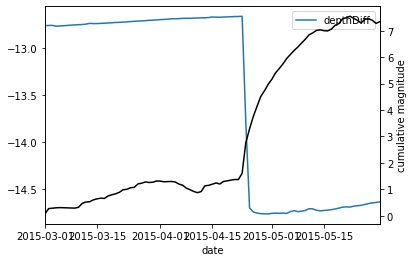

In [29]:
# fig, ax = plt.subplots(figsize=(20, 10))
import matplotlib.pyplot as plt 
df_plot.plot(y='depthDiff')
ax = df_plot['mw_cumsum'].plot(secondary_y=True, color='k')
ax.set_ylabel('cumulative magnitude')
# plt.xticks(rotation=90)
plt.show()

import matplotlib.pyplot as plt 

df.plot(x="land_cover", y=[1, 2, 3, 4, 5, 6], stacked=True, kind="bar")
ax = df['size'].plot(secondary_y=True, color='k', marker='o')
ax.set_ylabel('size')

plt.show()